# Discretization of a convection-diffusion problem

The convection-diffusion equation on the domain $\Omega$ is given by

$$
    -\mu \Delta u + v \cdot \nabla u = f,
$$

where $v$ is the velocity and $\mu$ is the diffusivity. The problem is also confined by the Dirichlet condition 
$u = g$ on $\partial \Omega$.

In [1]:
%matplotlib inline
import dolfin as df
import sympy as sp
import numpy as np
import tabulate
import matplotlib.pyplot as plt

from utils import x, y, z
import utils

df.set_log_level(30)

Below is the general solve function from `utils.py`:

In [2]:
# %load -s solve utils.py
def solve(mesh, degree, a, L, bc):
    '''Solve using Lagrange polynomials.'''
    V = df.FunctionSpace(mesh, "CG", degree)
    psi = df.TrialFunction(V)
    phi = df.TestFunction(V)
    u = df.Function(V)
    df.solve(a(psi, phi) == L(phi), u, bc(V))
    return u


Which is used in the implemented function for the convection-diffusion problem in one dimension using Dirichlet boundary conditions:

In [3]:
class ConvectionDiffusion:
    '''Convection-diffusion in 1D with Dirichlet boundary conditions.'''
    def __init__(self, mu, v, f, g):
        # convert constants to FEniCS friendly variables
        self.mu = utils.to_expression(mu) # diffusivity
        self.v = utils.to_expression(v)   # velocity
        self.f = utils.to_expression(f)   # source term
        self.g = utils.to_expression(g)   # Dirichlet boundary condition
        self.u = None
        
    def solve(self, N=32, order=1):
        mesh = df.UnitIntervalMesh(N)
        self.u = utils.solve(mesh, order, self.a, self.L, self.bc)
        return self.u
    
    def a(self, psi, phi):
        '''Left hand side.'''
        a_diff = self.mu*psi.dx(0)*phi.dx(0)*df.dx
        a_conv = self.v*psi.dx(0)*phi*df.dx
        return a_diff + a_conv
    
    def L(self, phi):
        '''Right hand side.'''
        return self.f*phi*df.dx
    
    def bc(self, V):
        '''u(0) = 0 & u(1) = 1.'''
        return df.DirichletBC(V, self.g, utils.boundary)

Reproduce plots from lecture notes:

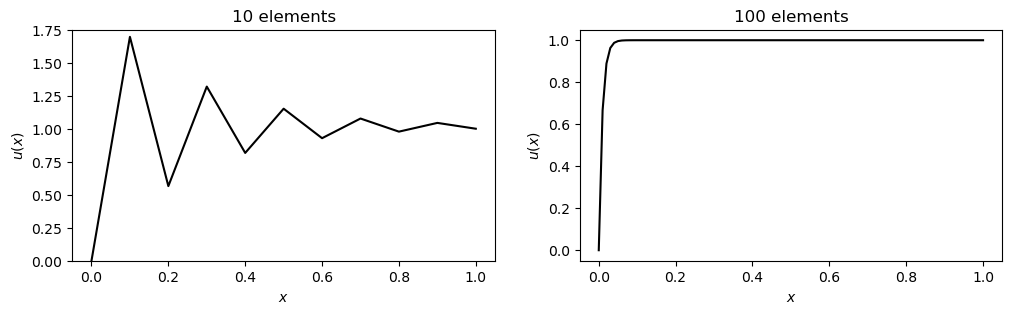

In [4]:
E0 = ConvectionDiffusion(mu=0.01, v=-1, f=0, g='x[0]')
plt.figure(figsize=(12, 3))
plt.subplot(121, title="10 elements", xlabel=r"$x$", ylabel=r"$u(x)$", ylim=(0, 1.75))
df.plot(E0.solve(N=10), color="black")
plt.subplot(122, title="100 elements", xlabel=r"$x$", ylabel=r"$u(x)$")
df.plot(E0.solve(N=100), color="black")
plt.show()

## Exercise 1

The central difference scheme defines the derivative as

$$
   [D_x u]_i = \frac{u_{i+1} - u_{i-1}}{2 h} .
$$

Transforming this into a matrix system $L u = u_x$, gives a matrix $L$ with non-zero elements in row $i$:

$$
     L_{i, i \pm 1} = \pm \frac{1}{2 h}. 
$$

Note that $L_{i \pm 1, i} = \mp \frac{1}{2 h}$, which means that $L$ is skew-symmetic, ($L_{i, j} = - L_{j, i}$).

The finite element method for describing $A u = u_x$ gives matrix elements

$$
    A_{i, j} = \int_\Omega \frac{\mathrm{d}\psi_i(x)}{\mathrm{d}x} \psi_j(x) \,\mathrm{d}x,
$$

where the trial functions $\psi_i$ and test functions $\psi_j$ are linear Lagrange polynomials. By defining the domain $x \in [x_s, x_f]$ and using integration by parts, we see that


$$
    A_{i, j} = 
    \left[\psi_i(x)\psi_j(x)\right]_{x_s}^{x_f} 
    - \int_{x_s}^{x_f}\frac{\mathrm{d}\psi_j(x)}{\mathrm{d}x} \psi_i(x)\,\mathrm{d}x 
    = \left[\psi_i(x)\psi_j(x)\right]_{x_s}^{x_f} - A_{j, i}.
$$

For the test and trial functions which are not on the boundary, we have that $\psi_i(x_s) = \psi_i(x_f) = 0$. This means that the non-boundary elements $A_{i, j}$ are skew-symmetric, as $A_{i, j} = - A_{j , i}$.

## Exercise 2

I assume example 3.1 is the standard Galerkin approximation.

This solves the diffusion-convection problem in one dimension on the unit interval. The equations are without a source term ($f(x) = 0)$, using negative velocity of $v(x) = -1$, and boundary conditions $u(0) = 0$ and $u(1) = 1$.

The exact solution in this case is

$$
    u_e = \frac{e^{-x/\mu} - 1}{e^{-1/\mu} - 1} .
$$

The corresponding FEniCS expression with a flexible value for $\mu$ is given below:

In [5]:
u_E2 = df.Expression('(exp(-x[0]/mu) - 1)/(exp(-1/mu) - 1)', degree=5, mu=0.01)

The Cea's constant is bounded by

$$
    C \geq \frac{||u_e - u_h||_{H_1}}{||u_e||_{k+1} h^{k}},
$$

where $u_e$ is the analytical solution and $u_h$ is its approximation on a mesh with element size $h$ and Lagrange elements of order $h$.

The corresponding implementation is given below:

In [6]:
class ConvectionDiffusion(ConvectionDiffusion):
    def Cea_constant(self, u_e):
        u = df.interpolate(u_e, self.V)
        H1 = utils.H1_norm(u - self.u)
        # H_{k+1}h^k
        Hk = self.norm(u, self.order + 1)*self.h**self.order
        return H1/Hk
    
    def norm(self, f, k):
        I = f*f
        for k in range(k):
            f = f.dx(0)
            I += f*f
        return df.sqrt(df.assemble(I*df.dx))
        
    @property
    def V(self):
        return self.u.function_space()
    
    @property
    def h(self):
        return self.V.mesh().hmin()
    
    @property
    def order(self):
        return self.V.ufl_element().degree()

Something is definitely wrong, the constant should not be this dependent on order and $h$.

In [7]:
E2 = ConvectionDiffusion(mu=0.01, v=-1, f=0, g='x[0]')
for mu in [0.1, 0.01, 0.001]:
    u_E2.mu = mu
    E2.mu = df.Constant(mu)
    print(f"\nmu is {mu:g}.")
    table = []
    for N in [10, 100, 1000]:
        values = [f"{1/N:.1g}"]
        for p in range(3):
            E2.solve(N=N, order=p+1)
            values.append(E2.Cea_constant(u_E2))
        table.append(values)
    print(tabulate.tabulate(table, headers=['h', 'P1', 'P2', 'P3']))


mu is 0.1.
    h          P1           P2          P3
-----  ----------  -----------  ----------
0.1    0.525379    0.0584092    0.00645008
0.01   0.0547001   0.00597772   0.00533159
0.001  0.00547229  0.000598016  0.00540689

mu is 0.01.
    h         P1         P2         P3
-----  ---------  ---------  ---------
0.1    15.9702    2.90258    0.278552
0.01    5.62214   0.587711   0.0648327
0.001   0.583342  0.0601231  0.0535822

mu is 0.001.
    h        P1        P2       P3
-----  --------  --------  -------
0.1    149.093   22.9442   2.61976
0.01   162.508   29.0431   2.7869
0.001   56.7524   5.87743  0.64836


## Exercise 3

The source term may be calculated for any exact solution $u_e$ with expressions for the velocity and the diffusivity.

Here is an implementation for manufactored solution for the convection-diffusion problem:

In [8]:
class ConvectionDiffusion(ConvectionDiffusion):
    @classmethod
    def MMS(cls, u_e, mu, v):
        u_x = sp.diff(u_e, x)
        u_xx = sp.diff(u_x, x)
        f = -mu*u_xx + v*u_x
        return cls(mu=mu, v=v, f=f, g=u_e)

Given $u_e = \sin(\pi x)$ with constant velocity $v = -1$ and arbitrary constant diffusivity we get: 

In [9]:
u_E3 = utils.to_expression(sp.sin(sp.pi*x))
    
for mu in [0.1, 0.01, 0.001]:
    E3 = ConvectionDiffusion.MMS(u_e=sp.sin(sp.pi*x), mu=mu, v=-1)
    print(f"\nmu is {mu:g}.")
    table = []
    for N in [10, 100, 1000]:
        values = [f"{1/N:.1g}"]
        for p in range(3):
            E3.solve(N=N, order=p+1)
            values.append(E3.Cea_constant(u_E3))
        table.append(values)
    print(tabulate.tabulate(table, headers=['h', 'P1', 'P2', 'P3']))


mu is 0.1.
    h           P1           P2          P3
-----  -----------  -----------  ----------
0.1    0.0617033    0.0141548    0.00168925
0.01   0.00615671   0.00143782   0.00159319
0.001  0.000615657  0.000145776  0.00742708

mu is 0.01.
    h           P1          P2          P3
-----  -----------  ----------  ----------
0.1    0.0810907    0.115001    0.00378607
0.01   0.00804075   0.0143126   0.00168313
0.001  0.000804001  0.00143367  0.00473021

mu is 0.001.
    h           P1         P2          P3
-----  -----------  ---------  ----------
0.1    0.082122     0.234274   0.00469852
0.01   0.00820746   0.140905   0.00372689
0.001  0.000820666  0.0143339  0.00233062


## Exercise 4

**Something must be wrong with this answer:**

Using the *streamline diffusion* or *Petrov-Galerkin*, the test functions are given by

$$
    \phi_\text{P-V} = \phi + \beta h v \nabla\phi,
$$

where $\beta$ is a new parameter, $h$ is element distance, and $\phi$ are the *common* Galerkin test functions.

This introduces strongly consistent diffusion. 

In [19]:
class ConvectionDiffusion(ConvectionDiffusion):
    def solve_sd(self, beta, N=32, order=1):
        mesh = df.UnitIntervalMesh(N)
        h = mesh.hmin()
        V = df.FunctionSpace(mesh, "CG", order)
        psi = df.TrialFunction(V)
        phi = df.TestFunction(V)
        # Petrov-Galerkin:
        phi_PG = phi + beta*h*self.v*phi.dx(0)
        self.u = df.Function(V)
        df.solve(self.a(psi, phi_PG) == self.L(phi_PG), self.u, self.bc(V))
        return self.u

Cea's constant using solution from Petrov-Galerkin:

In [28]:
for mu in [0.1, 0.01, 0.001]:
    E4 = ConvectionDiffusion.MMS(u_e=sp.sin(sp.pi*x), mu=mu, v=-1)
    print(f"\nmu is {mu:g}.")
    table = []
    for N in [10, 100, 1000]:
        values = [f"{1/N:.1g}"]
        for p in range(3):
            E4.solve_sd(beta=1, N=N, order=p+1)
            values.append(E4.Cea_constant(u_E3))
        table.append(values)
    print(tabulate.tabulate(table, headers=['h', 'P1', 'P2', 'P3']))


mu is 0.1.
    h        P1              P2              P3
-----  --------  --------------  --------------
0.1    0.479311    60.5432       1064.35
0.01   0.708136  9826.64            2.42787e+06
0.001  0.735679     1.03923e+06     2.58226e+09

mu is 0.01.
    h         P1            P2                P3
-----  ---------  ------------  ----------------
0.1    0.0117992       9.63507      38.5282
0.01   0.0863142    5342.72     894086
0.001  0.0954501  954355             2.35078e+09

mu is 0.001.
    h          P1            P2               P3
-----  ----------  ------------  ---------------
0.1    0.0541226        1.02991      3.28248
0.01   0.00160419     952.768    37738.6
0.001  0.0090074   524080            8.71222e+08


Using Petrov-Galerkin, the Cea's constant is bounded by

$$
    C \geq \frac{||u_e - u_h||_{sd}}{||u_e||_{k+1} h^{k}},
$$

where the SUPG norm is given by

$$
    ||u||_{sd} = \left(h||v\cdot \nabla u||^2_{H^1} + \mu |\nabla u|^2_{H^1} \right)^{1/2} .
$$

In [29]:
class ConvectionDiffusion(ConvectionDiffusion):
    def Cea_constant_sd(self, u_e):
        u = df.interpolate(u_e, self.V)
        # ||u - uh||_sd
        H1 = utils.H1_norm(self.v*(u - self.u).dx(0))
        H1_ = utils.H1_seminorm((u - self.u).dx(0))
        SUPG = df.sqrt(self.h*H1**2 + self.mu*H1_**2)
        # H_{k+1}h^k
        Hk = self.norm(u, self.order + 1)*self.h**self.order
        return H1/Hk
        
        return df.sqrt(self.h*norm + self.mu*semi_norm)

Constant values:

In [31]:
for mu in [0.1, 0.01, 0.001]:
    E4 = ConvectionDiffusion.MMS(u_e=sp.sin(sp.pi*x), mu=mu, v=-1)
    print(f"\nmu is {mu:g}.")
    table = []
    for N in [10, 100, 1000]:
        values = [f"{1/N:.1g}"]
        for p in range(3):
            E4.solve_sd(beta=1, N=N, order=p+1)
            values.append(E4.Cea_constant_sd(u_E3))
        table.append(values)
    print(tabulate.tabulate(table, headers=['h', 'P1', 'P2', 'P3']))


mu is 0.1.
    h        P1              P2               P3
-----  --------  --------------  ---------------
0.1    0.468958  2079.56         80256.9
0.01   0.68668      3.40347e+06      1.86563e+09
0.001  0.712564     3.6e+09          1.98678e+13

mu is 0.01.
    h         P1             P2              P3
-----  ---------  -------------  --------------
0.1    0.011448   328.317        1917.39
0.01   0.0825465    1.84878e+06     6.74403e+08
0.001  0.0911361    3.30593e+09     1.8064e+13

mu is 0.001.
    h          P1                P2             P3
-----  ----------  ----------------  -------------
0.1    0.0524506       35.0564       121.443
0.01   0.0015317   329529              1.85838e+07
0.001  0.00858622       1.81527e+09    6.572e+12


## Exercise 5

## Exercise 6

## Exercise 7

## Exercise 8